# Notebook For Theory Curves for Heterogeneous Ensembling -- Figure 3
Steps: 
(1) Sample degrees of connectivity from distribution
(2) Calculate learning curve for the given distribution of connectivity.
(3) combine the learning curves as desired.  Options: Mean and Maximum.

In [1]:
import numpy as np
import time
import copy
from tqdm import tqdm
import os
import sys
sys.path.append('../')

import importlib

import matplotlib as mpl
from matplotlib import pyplot as plt

from collections import OrderedDict

import torch
from torch.optim import SGD, Adam, lr_scheduler
device = 'cuda'

import importlib

import TheoryCurves
importlib.reload(TheoryCurves)

import auxFuncs
importlib.reload(auxFuncs)

import pytz
from datetime import datetime
from dateutil.relativedelta import relativedelta
tz = pytz.timezone('US/Eastern')

def time_now():
    return datetime.now(tz)

def time_diff(t_a, t_b):
    t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
    return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)

In [2]:
colors_base = ['tab:blue', 'tab:red', 'tab:green', 'tab:purple', 'tab:orange', 'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan']
linestyles = ['-', '--', ':', '-.']
markerstyles = ['.','*','x']

In [3]:
#Width and height of axes.
w=2.5
h=2
plt.rcParams.update({'font.size': 12, 'figure.figsize': [w,h]})

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['legend.title_fontsize'] = 'small'

#Helper Function for setting figure size by axis size.
#set_size(w,h,ax)
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

In [4]:
from scipy.stats import gamma

def draw_gamma_numbers(mean, variance, size):
    # Calculate the shape and scale parameters based on mean and variance
    shape = mean ** 2 / variance
    scale = variance / mean

    # Generate random numbers from the gamma distribution
    random_numbers = gamma.rvs(shape, scale=scale, size=size)
    return random_numbers

# Example usage
mean = 1/5
std = 0.01
variance = std**2
size = 10000

random_numbers = draw_gamma_numbers(mean, variance, size)

## Calculate Theory Curve: A_list

Give mean and std of gamma distribution, determine mean learning curve

In [5]:
def runHomVHet_exclusive(k, mean, std, lam, zeta, numAlphas = 100, alpha_max = 1, num_trials = 100, renorm_nus = False):
    alpha_min = alpha_max/numAlphas
    alphas_theory = np.linspace(alpha_min, alpha_max, numAlphas)
    
    #Get Homogeneous Error Curve
    nus = [mean for i in range(k)]
    homErrorCurve = TheoryCurves.getGlobCorrErrorCurve(alphas_theory, nus, c, lam, zeta, eta, exclusive = True)

    #Get Heterogeneous Error Curves
    hetErrorCurves = np.zeros((numAlphas, num_trials))
    for trial in tqdm(range(num_trials)):
        nus = draw_gamma_numbers(mean, std**2, k)
        if renorm_nus:
            nus = mean*nus/np.mean(nus)
        hetErrorCurves[:, trial] = TheoryCurves.getGlobCorrErrorCurve(alphas_theory, nus, c, lam, zeta, eta, exclusive = True)
        
    return alphas_theory, homErrorCurve, hetErrorCurves

### Loop over Regularization, Label Noise, and standard deviation (as a fraction of the mean)

In [6]:
#Fixed Parameters
num_trials = 100
k = 10
std_fracs = [1/4, 1/2, 1, 2]
mean = 1/k

#Use c = 0.  Isotropic data is sufficient for the point this figure makes.
c = 0
eta = 0

#Varying Parameters
lams = [1e-3, 1e-1]
zetas = [0]

100%|██████████| 100/100 [00:09<00:00, 10.80it/s]


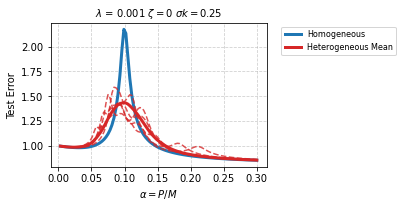

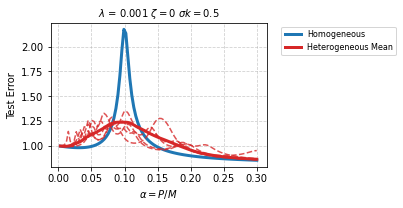

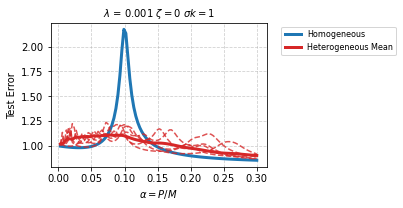

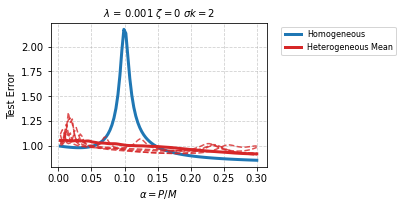

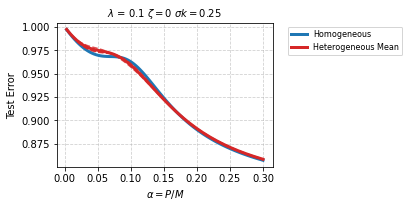

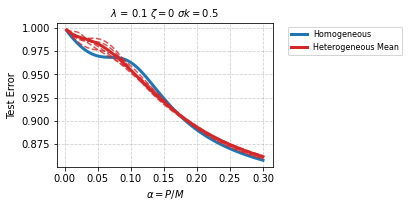

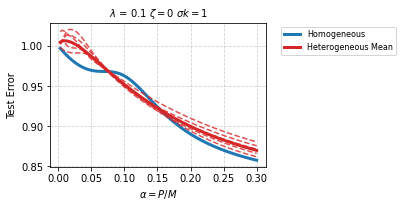

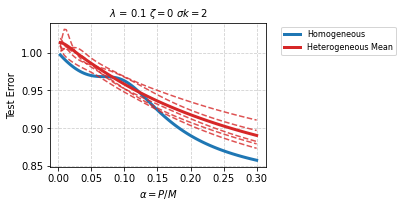

In [36]:
for lamInd, lam in enumerate(lams):
    for zetaInd, zeta in enumerate(zetas):
        for stdInd, std_frac in enumerate(std_fracs):
            std = std_frac*mean
            alphas_theory, homErrorCurve, hetErrorCurves = runHomVHet_exclusive(k, mean, std, lam, zeta, alpha_max=3/k, num_trials = num_trials, renorm_nus = True)
            meanHetErrorCurve = np.mean(hetErrorCurves, axis=1)
            fig, ax = plt.subplots()
            ax.plot(alphas_theory, homErrorCurve, label = 'Homogeneous', color = colors_base[0], lw = 3)
            ax.plot(alphas_theory, meanHetErrorCurve, label = 'Heterogeneous Mean', color = colors_base[1], lw = 3)

            for i in range(5):
                ax.plot(alphas_theory, hetErrorCurves[:,i], lw = 1.5, color = colors_base[1], ls = '--', alpha = .8)

            ax.set_ylabel('Test Error')
            ax.set_xlabel(r'$\alpha = P/M$')
            ax.set_title(r'$\lambda$ = ' + str(lam) + r' $\zeta = $' + str(zeta) + r' $\sigma k = $' + str(std_frac))

            #ax.set_xlim([0, ax.get_xlim()[1]])

            #ax.legend(custom_lines, ['Shift = ' + str(shift) for shift in shift_list] + ['K = '+str(K) for K in KVals], bbox_to_anchor = (1.9, 1), loc = 'upper right')
            ax.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')
            ax.grid(True, linestyle='--', alpha=0.6)  # Add a grid
            set_size(3,2)
            fig.savefig('HomVsHet_'+'lam_' + str(lam) + '_zeta_' + str(zeta)+'_stdfrac_' + str(std_frac)+'.svg', dpi = 300, bbox_inches='tight')

### Compare learning curves and typical maximum of learning curves for varying standard deviation

In [10]:
def runHet(k, mean, std, lam, zeta, eta, c, alphas_theory, num_trials = 100, renorm_nus = False):
    
    num_alphas = len(alphas_theory)
    
    #If std is zero, gets the homogeneous error curve
    if std == 0:
        nus = [mean for i in range(k)]
        homErrorCurve = TheoryCurves.getGlobCorrErrorCurve(alphas_theory, nus, c, lam, zeta, eta, exclusive = True)
        ErrorCurves = np.hstack([homErrorCurve.reshape(-1,1) for i in range(num_trials)])
        HomAsymptoticError = TheoryCurves.getGlobCorrError(np.inf, nus, c, lam, zeta, eta, exclusive = True)
        AsymptoticErrors = np.tile(HomAsymptoticError, num_trials).reshape(-1)
        return ErrorCurves, AsymptoticErrors

    #Get Heterogeneous Error Curves
    ErrorCurves = np.zeros((num_alphas, num_trials))
    AsymptoticErrors = np.zeros(num_trials)
    for trial in tqdm(range(num_trials)):
        nus = draw_gamma_numbers(mean, std**2, k)
        if renorm_nus:
            nus = mean*nus/np.mean(nus)
        curErr = TheoryCurves.getGlobCorrErrorCurve(alphas_theory, nus, c, lam, zeta, eta, exclusive = True)
        ErrorCurves[:, trial] = curErr
        AsymptoticErrors[trial] = TheoryCurves.getGlobCorrError(np.inf, nus, c, lam, zeta, eta, exclusive = True)
        
    return ErrorCurves, AsymptoticErrors

In [11]:
k = 10
mean = 1/k
num_stds = 20
lam = .001
zeta = 0
eta = 0
c = 0
stds = np.linspace(0, 6*mean, num_stds)

In [12]:
num_alphas = 60
alpha_max = 2.5*mean
alphas_theory = np.linspace(alpha_max/num_alphas, alpha_max, num_alphas)
meanErrorCurves = np.zeros((num_alphas, num_stds))
meanMaximums = np.zeros(num_stds)
stdMaximums = np.zeros(num_stds)
meanAsymptoticErrors = np.zeros(num_stds)
stdAsymptoticErrors = np.zeros(num_stds)
for stdInd, std in enumerate(stds):
    ErrorCurves, AsymptoticErrors = runHet(k, mean, std, lam, zeta, eta, c, alphas_theory, renorm_nus = True)
    meanErrorCurve = np.mean(ErrorCurves, axis = 1)
    meanErrorCurves[:, stdInd] = meanErrorCurve
    curMaximums = np.max(ErrorCurves, axis = 0)
    meanMaximums[stdInd] = np.mean(curMaximums)
    stdMaximums[stdInd] = np.std(curMaximums)
    meanAsymptoticErrors[stdInd] = np.mean(AsymptoticErrors)
    stdAsymptoticErrors[stdInd] = np.std(AsymptoticErrors)

100%|██████████| 100/100 [00:04<00:00, 20.04it/s]


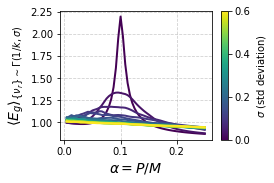

In [15]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# Define the colormap
cmap = cm.get_cmap('viridis')

# Create a normalized color map
norm = colors.Normalize(vmin=stds.min(), vmax=stds.max())

# Now Plot mean learning curves and mean maximum as a function of variance
fig, ax = plt.subplots()
for stdInd, std in enumerate(stds):
    color = cmap(norm(std))  # Get the color from the colormap
    ax.plot(alphas_theory ,meanErrorCurves[:, stdInd], color=color, linewidth=2)

set_size(3,2)
ax.set_xlabel(r'$\alpha = P/M$', fontsize=14)  # Increase the fontsize
ax.set_ylabel(r'$\langle E_g \rangle_{\{\nu_r\} \sim \Gamma(1/k, \sigma)}$', fontsize=14)  # Increase the fontsize
ax.grid(True, linestyle='--', alpha=.6)  # Add a grid
#plt.tick_params(labelsize=12)  # Increase the size of the ticks labels

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm)
cbar.set_label(r'$\sigma$ (std deviation)')#, fontsize=14)
plt.tight_layout()
plt.savefig('ErrVaryStd.svg', bbox_inches = 'tight', dpi=300)  # Save the figure in high resolution
plt.show()

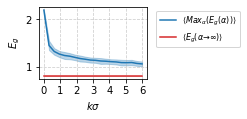

In [17]:
#Plot mean maximum as a function of variance
fig, ax = plt.subplots()
# plot mean maximum as a function of variance with shaded error
ax.plot(stds/mean, meanMaximums, color=colors_base[0], label=r'$\langle Max_{\alpha}(E_g(\alpha)) \rangle$')
ax.fill_between(stds/mean, meanMaximums - stdMaximums, meanMaximums + stdMaximums, color=colors_base[0], alpha=0.3)

# plot mean asymptotic errors as a function of variance with shaded error
ax.plot(stds/mean, meanAsymptoticErrors, color=colors_base[1], label=r'$\langle E_g(\alpha \to \infty) \rangle$')
ax.fill_between(stds/mean, meanAsymptoticErrors - stdAsymptoticErrors, meanAsymptoticErrors + stdAsymptoticErrors, color=colors_base[1], alpha=0.3)
ax.grid(True, linestyle='--', alpha=0.6)  # Add a grid
ax.set_xlabel(r'$k\sigma$')
ax.set_ylabel(r'$E_g$')
ax.set_xticks([0,1,2,3, 4, 5, 6])
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
set_size(1.5,1)
plt.savefig('MaxAsymptErrVsSTD.svg', bbox_inches = 'tight', dpi=300)  # Save the figure in high resolution
plt.show()

In [25]:
# #Plot mean maximum as a function of variance
# fig, ax = plt.subplots()
# ax.errorbar(stds/mean, meanMaximums, stdMaximums, color = colors_base[0], label = r'Mean Max $E_g$')
# ax.errorbar(stds/mean, meanAsymptoticErrors, stdAsymptoticErrors, color = colors_base[1], label = r'$\alpha \to \infty$')
# #ax.axvline(x = 1, color = 'black', ls = '--')
# ax.set_xlabel(r'$k\sigma$')
# ax.set_xticks([0,1,2,3, 4, 5, 6])
# #ax.set_ylabel(r'Mean Max $E_g$')
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import gamma
import matplotlib.cm as cm

def plot_gamma_pdf(mean, std_devs, spacing=1):
    deltastd = std_devs[1]-std_devs[0]
    numCurves = std_devs.shape[0]
    print(numCurves)
    x = np.linspace(0, 5 * mean, 1000)

    fig, ax = plt.subplots()
    cmap = cm.get_cmap('plasma')
    colors = cmap(np.linspace(0, 1, numCurves))
    
    bounds = np.linspace(0, std_devs[-1]+deltastd, numCurves+1)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    for i in range(0, numCurves, spacing):
        std_dev = std_devs[i]
        shape = (mean / std_dev) ** 2
        scale = std_dev ** 2 / mean
        y = gamma.pdf(x, shape, scale=scale)

        color = colors[i]
        ax.plot(x, y, label=round(std_dev, 3), color=color)

    ax.set_xlabel(r'$\nu$')
    ax.set_ylabel('Probability Density')
    ax.set_yscale('log')
    ax.set_xlim([0, .3])
    ax.set_ylim([0.09, 25])
    
    # Create a discrete colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, boundaries=bounds, ticks=bounds[:-1]+deltastd/2)

    cbar_labels = [round(sd, 3) for sd in np.linspace(std_devs[0], std_devs[-1], len(cbar.get_ticks()))]
    cbar.ax.set_yticklabels(cbar_labels)  # vertically oriented colorbar
    cbar.set_label(r'Standard Dev. $\sigma$')
    ax.set_xticks([0,.1,.2,.3])
    ax.grid(True, linestyle='--', alpha=0.6)  # Add a grid
    set_size(2,4/3)
    plt.savefig('GammaDistMean.1.svg', bbox_inches='tight', dpi = 300, transparent = True)
    plt.show()

10


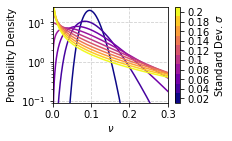

In [24]:
plot_gamma_pdf(1/10, np.round(np.linspace(.2/10, 2/10, 10), 2), spacing = 1)